<a href="https://www.kaggle.com/chiragtagadiya/shopee-basic-autoencoder?scriptVersionId=88738933" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Shopee-Product-Matching
![Shopee](https://cdn.lynda.com/course/563030/563030-636270778700233910-16x9.jpg)


1. [Business Problem](#motivation)  
2. [EDA and Data Exploration](#eda)
3. [Convolution AutoEncoder](#cae)
4. [Visualize Prediction](#testing)
5. [Creating Index](#indexing)


# 1. Business Problem
<!-- <div id="motivation"></div>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#483d8b; border:0; color:white' role="tab" aria-controls="home"><center></center></h1> -->


Shopee is the leading e-commerce platform in Southeast Asia and Taiwan. Customers appreciate its easy, secure, and fast online shopping experience tailored to their region. The company also provides strong payment and logistical support along with a 'Lowest Price Guaranteed' feature on thousands of Shopee's listed products.

Finding near-duplicates in large datasets is an important problem for many online businesses. In Shopee's case, everyday users can upload their own images and write their own product descriptions, adding an extra layer of challenge. Your task is to identify which products have been posted repeatedly. The differences between related products may be subtle while photos of identical products may be wildly different!

Two different images of similar wares may represent the same product or two completely different items. Retailers want to avoid misrepresentations and other issues that could come from conflating two dissimilar products. Currently, a combination of deep learning and traditional machine learning analyzes image and text information to compare similarity. But major differences in images, titles, and product descriptions prevent these methods from being entirely effective.

In this competition, we’ll apply our machine learning skills to build a model that predicts which items are the same products.


## 2. EDA and Dataset Exploration
<!-- 

<div id="eda"></div>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#483d8b; border:0; color:white' role="tab" aria-controls="home"><center></center></h1> -->

In this competition, we have items with an image and title. For the train data, the column label_group indicates the ground truth of which items are similar. We need to build a model that finds these similar images based on their image and title's text. In this notebook we explore some tools to help us.


### 2.1 Load Libraries

In [47]:
%config Completer.use_jedi = False

In [48]:
## Load Libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as im
import tqdm
import cv2
%matplotlib inline
import PIL
import gc
import time
from skimage import io, transform
import pickle
## Deep Learning Pytorch library
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models






### 2.2 Load Dataset

In [49]:
# configuration params
BASE_PATH = '../input/shopee-product-matching/'
TRAIN_PATH = BASE_PATH + "train_images/"
TEST_PATH = BASE_PATH + "test_images/"

BATCH_SIZE=64
INP_WIDTH=256
INP_HEIGHT=256
MODEL_PATH='output/'

In [50]:
test_df = pd.read_csv(BASE_PATH+'test.csv')
train_df = pd.read_csv(BASE_PATH+'train.csv')


### 2.3 Display Duplicated items

using the label_group feature which indicated the item posting belongs to same product, we can display duplicated products.

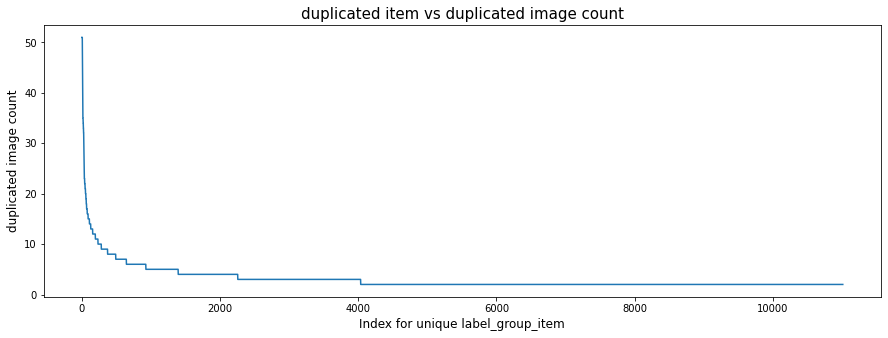

In [51]:
labelGroups = train_df.label_group.value_counts()
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(labelGroups)), labelGroups.values)
plt.xlabel("Index for unique label_group_item", size=12)
plt.ylabel("duplicated image count", size=12)
plt.title("duplicated item vs duplicated image count", size=15)
plt.show()


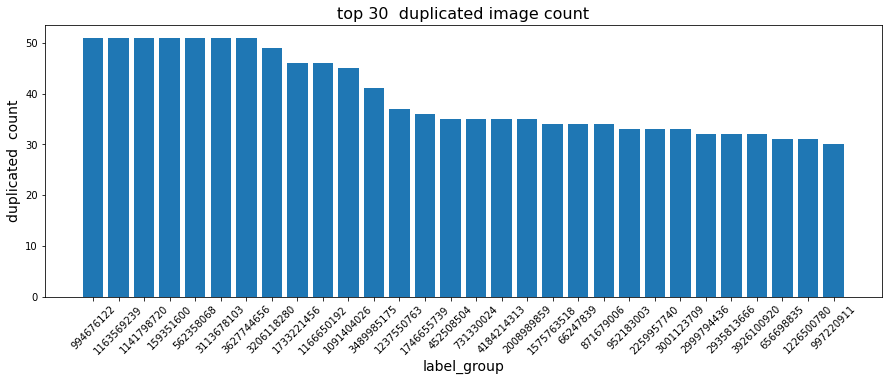

In [52]:
plt.figure(figsize=(15,5))
plt.bar(labelGroups.index[:30].astype('str'), labelGroups.values[:30])
plt.xlabel("label_group", size=14)
plt.xticks(rotation = 45)
plt.ylabel("duplicated  count", size=14)
plt.title("top 30  duplicated image count", size=16)
plt.show()

In [53]:
def display_image(df, COLS=6, ROWS=4, path=BASE_PATH, random=False):
    # iterate over rows     
    for k in range(ROWS):
        # for each row we will set the size of figure
        plt.figure(figsize=(20,5))
        # iterate over all the columns
        for j in range(COLS):
            # if random flag is true get the random index from data frame
            if random: 
                row = np.random.randint(0,len(df))
            else:
                
                row = COLS*k + j
                
            # image name this will help collect the true path of image
            name = df.iloc[row,1]
            # title of the image
            title = df.iloc[row,3]
            img = im.imread(path+name)
            plt.subplot(1,COLS,j+1)
            plt.title(title[:30])
            plt.axis('off')
            # display image
            plt.imshow(img)
        plt.show()
        


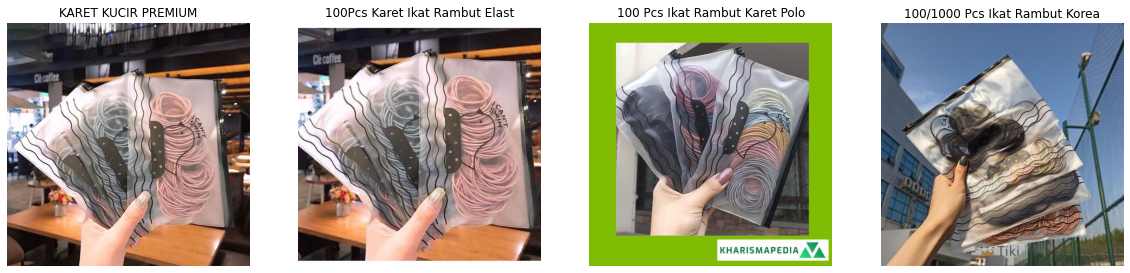

In [54]:
label_group_sample =train_df[train_df['label_group'] == 994676122]
display_image(label_group_sample, random=False, ROWS=1, COLS=4, path = BASE_PATH + 'train_images/')

### 2.4 Observation

- We can clearly see that all the above images belongs to same label_group, some of the images **(first row)** are different than others. 
- There are certain images that is almost identical, only difference is **zoom level,backgroud and orientation**.
- **Zoom Level Variation :** [Row 1, Col 2] [Row 2, Col 3] 
- **Background and Orientation Variation :** [ last Row ]
- If we check the title of this products we will find slight different.
- This variation makes this problem very interesting!


****************************************
*** TOP 1 DUPLICATED ITEM: 994676122
****************************************


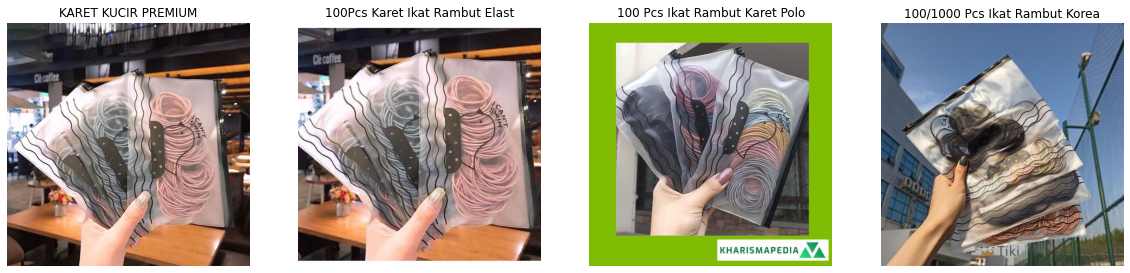

****************************************
*** TOP 2 DUPLICATED ITEM: 1163569239
****************************************


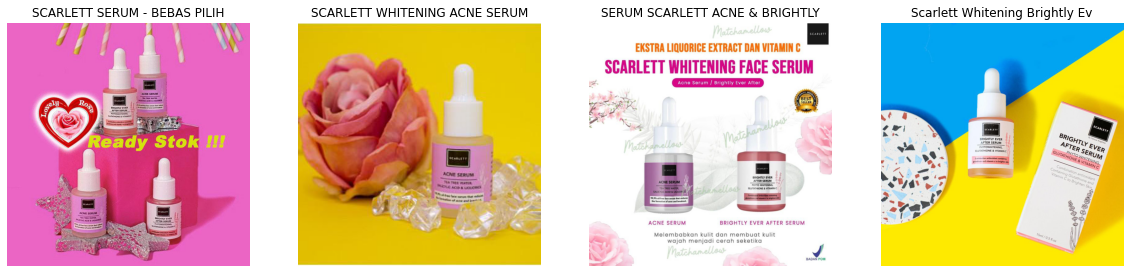

In [55]:
for k in range(2):
    print('*'*40)
    print('*** TOP %i DUPLICATED ITEM:'%(k+1),labelGroups.index[k])
    print('*'*40)
    top = train_df.loc[train_df.label_group==labelGroups.index[k]]
    display_image(top, random=False, ROWS=1, COLS=4, path = BASE_PATH + 'train_images/')

In [56]:
train_df['title'].describe()

count                                              34250
unique                                             33117
top       Koko syubbanul muslimin koko azzahir koko baju
freq                                                   9
Name: title, dtype: object

In [57]:
top_frequent_title_df = train_df[train_df['title'] == 'Koko syubbanul muslimin koko azzahir koko baju']
top_frequent_title_df



posting_id                                 image  \
11299   train_437123271  54ebc3ef04985b9f90e43fa6eaa14fa8.jpg   
18979  train_1091145610  8f1310e4dfdb14d4f6e6e54814af8a56.jpg   
22336  train_2035900367  a7b5b681b23b5834dfe0454f883697c5.jpg   
23224  train_2183656041  ae64de9e8d31ae6d049581aec42e0442.jpg   
25616  train_2886681369  bf9c11baa39f23f1d34cd1fe617af88c.jpg   
26425  train_1064632030  c5b2b6180559ea2f341c48527031aa33.jpg   
27834  train_3378928984  d0403c82fbb237857869ff14fb4c9765.jpg   
29611  train_3767027123  ddd51a41c49b2fb6a4ad7b3b4e4566d9.jpg   
32475   train_556227538  f35f6a4960db6d9c589b2cf7e58f0de6.jpg   

            image_phash                                           title  \
11299  daa5b58127c83cda  Koko syubbanul muslimin koko azzahir koko baju   
18979  fe84bef66060413b  Koko syubbanul muslimin koko azzahir koko baju   
22336  cbe91696b54be148  Koko syubbanul muslimin koko azzahir koko baju   
23224  be93e479811886f9  Koko syubbanul muslimin koko azzahir koko baju   
25616  9be469c17e8914cb  Koko syubbanul muslimin koko azzahir koko baju   
26425  ecf00f879904f0f9  Koko syubbanul muslimin koko azzahir koko baju   
27834  e0bca5d826d8da87  Koko syubbanul muslimin koko azzahir koko baju   
29611  c9af52bc94c95781  Koko syubbanul muslimin koko azzahir koko baju   
32475  be945bd1c06ee690  Koko syubbanul muslimin koko azzahir koko baju   

       label_group  
11299   1241012862  
18979    373863554  
22336    536452526  
23224   1918908464  
25616    373863554  
26425   1918908464  
27834    373863554  
29611   1912222471  
32475   1663491238

### 2.5 Top Frequent Title and Label groups

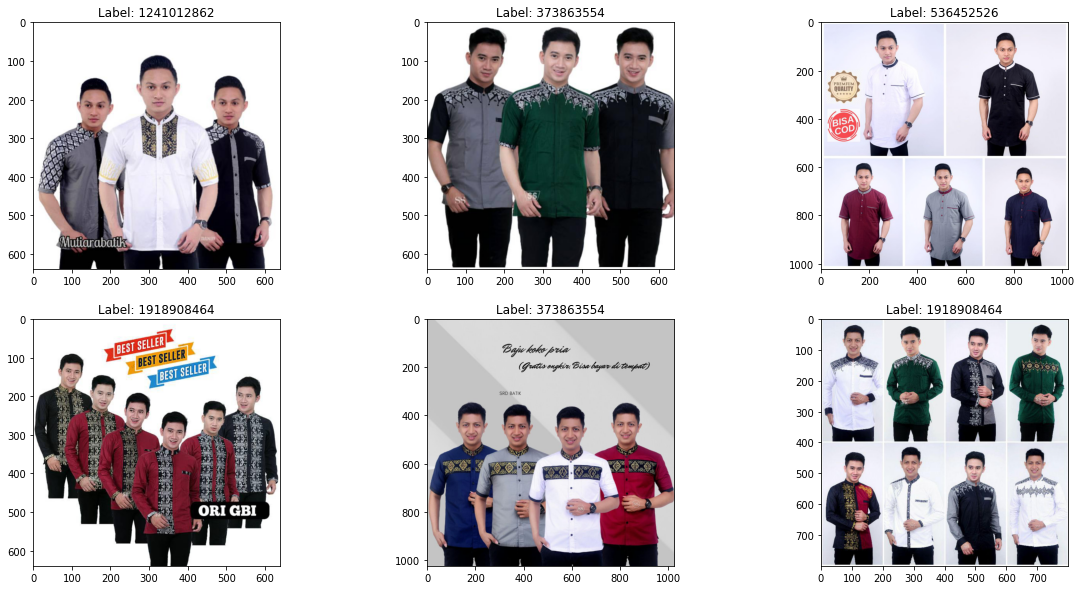

In [58]:

# create subplot 4 rows 3 columns
figure, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
ax = ax.flatten()

for idx,imageIndexId in enumerate(top_frequent_title_df.index[:6]):
    imageId = train_df.loc[imageIndexId]['image']
    target_label = train_df.loc[imageIndexId]['label_group']
    ax[idx].imshow(im.imread("../input/shopee-product-matching/train_images/{}".format(imageId)).squeeze())
    ax[idx].title.set_text("Label: {}".format(target_label))
    


### 2.6 Top Frequent imageHash and labelGroups


In [59]:
top_frequent_image_hash = train_df[train_df['image_phash'] == 'fad28daa2ad05595' ] 
top_frequent_image_hash = top_frequent_image_hash.sort_values(by='title')
top_frequent_image_hash

posting_id                                 image  \
3916   train_1062957964  1dbf735adb93d54e6340af02f9b5472e.jpg   
33406   train_506533947  f9dc2cf9ed811fec7cbc9d5120638f0c.jpg   
29342  train_3098940485  dbdc85177d752dbbfd5b9e8b1dfe51bf.jpg   
5919   train_4270145275  2cd540e8c1810d1d1aaf3d73b8116cdc.jpg   
33407   train_264921119  f9dc2cf9ed811fec7cbc9d5120638f0c.jpg   
32375  train_2963418781  f295135f60f6932599306d338c872efd.jpg   
27709  train_3045742003  cf718bef78980e0e8b250e7ce96a10ce.jpg   
12248  train_1943986671  5c1e0f695fb5ab7b0d83de0fef4bfdaf.jpg   
1978   train_1942146514  0f459b1e8aa89ee9e79b2ec95440e9c3.jpg   
1979   train_1720530417  0f459b1e8aa89ee9e79b2ec95440e9c3.jpg   
33408   train_710912300  f9dc2cf9ed811fec7cbc9d5120638f0c.jpg   
17760  train_3141138577  8591ed8b5bc268e386a66206bb233b2f.jpg   
22290   train_973648209  a75890cf09d9c9487ee3530d856ab456.jpg   
8993    train_989190235  43af52158ed9acd8274a7d6d6c109dfc.jpg   
33409  train_2659922285  f9dc2cf9ed811fec7cbc9d5120638f0c.jpg   
3917   train_4124267548  1dbf735adb93d54e6340af02f9b5472e.jpg   
579    train_1015625393  04a00bccb7f1560e755f5f1def73db59.jpg   
33410  train_3501921844  f9dc2cf9ed811fec7cbc9d5120638f0c.jpg   
30884  train_3653456112  e749e5b1ef5b1b2d74fa9bdcb37e7ba7.jpg   
20893  train_1224240247  9ce299d95fb2a89ff4ecb207cb4f0fe6.jpg   
27389  train_2096814076  ccec47f17a3d740f9bdd9fe695a14b62.jpg   
25860  train_2764460294  c13a9c475a18cc5b73c5003d10084e6d.jpg   
27390  train_1112724160  ccec47f17a3d740f9bdd9fe695a14b62.jpg   
10768  train_3574291998  50ef370271e8c7e00eaaf018c9cd93dd.jpg   
24347  train_3061369935  b6b351c0f1187f86689ec203859f86a7.jpg   
26663  train_2216662733  c791b68707f380c959c19569ff4746d2.jpg   

            image_phash                                              title  \
3916   fad28daa2ad05595  MURAH!! SUGAR BABY Perlak (Perlak Karet Waterp...   
33406  fad28daa2ad05595                       PERLAK KARET BAYI SUGAR BABY   
29342  fad28daa2ad05595  Perlak Bayi Sugar Baby ( Perlak Karet Waterpro...   
5919   fad28daa2ad05595  Perlak Bayi Sugar Baby (Alas Ompol Waterproof ...   
33407  fad28daa2ad05595  Perlak Bayi Sugar Baby (Perlak Karet Waterproo...   
32375  fad28daa2ad05595  Perlak Bayi Sugar Baby - Alas Ompol Bayi Sugar...   
27709  fad28daa2ad05595          Perlak Bayi Waterproof Organic SUGAR BABY   
12248  fad28daa2ad05595  Perlak Bayi organik SUGAR BABY / Perlak karet ...   
1978   fad28daa2ad05595  Perlak Karet Organic Bayi Sugar Baby uk 90x60 ...   
1979   fad28daa2ad05595  Perlak Karet Organik Bayi Sugar Baby uk 90x60 ...   
33408  fad28daa2ad05595  Perlak Ondo Bayi SUGAR BABY Motif | Air Bubble...   
17760  fad28daa2ad05595                          Perlak Sugar Baby 90x60cm   
22290  fad28daa2ad05595       Perlak Sugarbaby Organik / Perlak Bayi Karet   
8993   fad28daa2ad05595  Perlak Waterproof Bayi SUGAR BABY 90 x 60 cm O...   
33409  fad28daa2ad05595  Sugar Baby Organic Healthy - Premium Air Fille...   
3917   fad28daa2ad05595  Sugar Baby Organic Healthy Cot Sheet - Perlak ...   
579    fad28daa2ad05595   Sugar Baby Organic Healthy Cot Sheet Perlak Bayi   
33410  fad28daa2ad05595  Sugar Baby Organic Healthy Cot Sheet Perlak On...   
30884  fad28daa2ad05595  Sugar Baby Organic Healthy Premium Rubber Cot ...   
20893  fad28daa2ad05595               Sugar Baby Perlak / Rubber Cot Sheet   
27389  fad28daa2ad05595  Sugar Baby Perlak Ompol Bayi Karet Organic Hea...   
25860  fad28daa2ad05595  Sugar Baby Perlak Organic Healthy Cot Sheet Mo...   
27390  fad28daa2ad05595  Sugar Baby Perlak ompol karet bayi organic  / ...   
10768  fad28daa2ad05595  Sugar Baby Pink Kitten Organic Healthy Cot She...   
24347  fad28daa2ad05595           Sugarbaby Perlak / Sugar Baby Alas Ompol   
26663  fad28daa2ad05595  Sugarbaby Perlak Bayi Sugar Baby - Perlak Kare...   

       label_group  
3916     997220911  
33406    997220911  
29342    997220911  
5919     997220911  
33407    997220911  
32375    997220911  
277

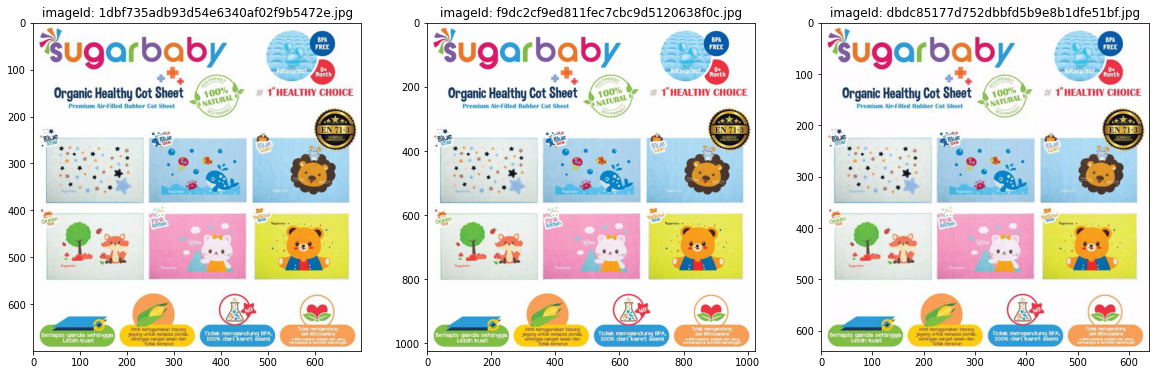

In [60]:

# create subplot 4 rows 3 columns
figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
# flatten the index so we can easily put image using indexing
ax = ax.flatten()

for idx,imageIndexId in enumerate(top_frequent_image_hash.index[:3]):
    
    
    imageId = train_df.loc[imageIndexId]['image']
    ax[idx].imshow(im.imread("../input/shopee-product-matching/train_images/{}".format(imageId)).squeeze())
    ax[idx].title.set_text("imageId: {}".format(imageId))
    

### 2.7 Top Frequent image url and label group


In [61]:
top_frequent_image_url = train_df[train_df['image'] == "0cca4afba97e106abd0843ce72881ca4.jpg"]
top_frequent_image_url

posting_id                                 image  \
1651  train_3068759534  0cca4afba97e106abd0843ce72881ca4.jpg   
1652  train_1049463374  0cca4afba97e106abd0843ce72881ca4.jpg   
1653  train_2420615645  0cca4afba97e106abd0843ce72881ca4.jpg   
1654  train_1236710293  0cca4afba97e106abd0843ce72881ca4.jpg   
1655   train_443869273  0cca4afba97e106abd0843ce72881ca4.jpg   
1656  train_1381575164  0cca4afba97e106abd0843ce72881ca4.jpg   
1657  train_2085280992  0cca4afba97e106abd0843ce72881ca4.jpg   
1658  train_4226152332  0cca4afba97e106abd0843ce72881ca4.jpg   
1659  train_1437764574  0cca4afba97e106abd0843ce72881ca4.jpg   
1660  train_3993385953  0cca4afba97e106abd0843ce72881ca4.jpg   
1661   train_493140267  0cca4afba97e106abd0843ce72881ca4.jpg   
1662   train_419018435  0cca4afba97e106abd0843ce72881ca4.jpg   
1663  train_2514153495  0cca4afba97e106abd0843ce72881ca4.jpg   
1664  train_2951822530  0cca4afba97e106abd0843ce72881ca4.jpg   
1665   train_584097694  0cca4afba97e106abd0843ce72881ca4.jpg   

           image_phash                                              title  \
1651  d0c0ea37bd9acce0  BUBBLE PACK UNTUK PACKING TAMBAHAN 1BUBBLE UNT...   
1652  d0c0ea37bd9acce0                                        BUBBLE WARP   
1653  d0c0ea37bd9acce0      BUBBLE WRAP - EXTRA PACKING UNTUK BARANG ANDA   
1654  d0c0ea37bd9acce0                    Bubble Warp Pengaman Pengiriman   
1655  d0c0ea37bd9acce0                                        Bubble Wrap   
1656  d0c0ea37bd9acce0                 Bubble Wrap untuk ekstra packaging   
1657  d0c0ea37bd9acce0                                         Buble Wrap   
1658  d0c0ea37bd9acce0                    EXTRA BUBBLE WRAP UNTUK PACKING   
1659  d0c0ea37bd9acce0                                  Extra Bubble Wrap   
1660  d0c0ea37bd9acce0               Extra Bubble Wrap Pengaman Packingan   
1661  d0c0ea37bd9acce0                       PACKING TAMBAHAN BUBBLE WRAP   
1662  d0c0ea37bd9acce0                               Tambahan Bubble Wrap   
1663  d0c0ea37bd9acce0  Tambahan Bubble wrap / Plastik Bubble Pelindun...   
1664  d0c0ea37bd9acce0      Tambahan Extra Bubble Wrap Pengaman Packingan   
1665  d0c0ea37bd9acce0                           bubble wrap - BUBLE WRAP   

      label_group  
1651   4198148727  
1652   2403374241  
1653   4198148727  
1654   4198148727  
1655   4198148727  
1656   4198148727  
1657   4198148727  
1658   2403374241  
1659   4198148727  
1660   2403374241  
1661   4198148727  
1662   4198148727  
1663   4198148727  
1664   4198148727  
1665   4198148727

We can see from the above table that we have two different label_group ( label_group : 2403374241, 4198148727) for same image.

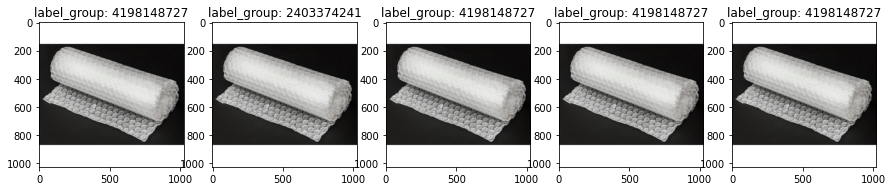

In [62]:
# create subplot 4 rows 3 columns
figure, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
ax = ax.flatten()

for idx,imageIndexId in enumerate(top_frequent_image_url.index[:5]):
    imageId = train_df.loc[imageIndexId]['image']
    label_group = train_df.loc[imageIndexId]['label_group']
    ax[idx].imshow(im.imread("../input/shopee-product-matching/train_images/{}".format(imageId)).squeeze())
    ax[idx].title.set_text("label_group: {}".format(label_group))
    

In [63]:
top_frequent_image_group_by_labels = top_frequent_image_url.groupby('label_group')
top_frequent_image_group_by_labels.groups

{2403374241: [1652, 1658, 1660], 4198148727: [1651, 1653, 1654, 1655, 1656, 1657, 1659, 1661, 1662, 1663, 1664, 1665]}

In [64]:
filtered_2403374241 = train_df[train_df['label_group'] == 2403374241]
filtered_2403374241

posting_id                                 image  \
909    train_3284960524  071d2deb4a8cad2c6ae930b96cd40664.jpg   
1652   train_1049463374  0cca4afba97e106abd0843ce72881ca4.jpg   
1658   train_4226152332  0cca4afba97e106abd0843ce72881ca4.jpg   
1660   train_3993385953  0cca4afba97e106abd0843ce72881ca4.jpg   
4567   train_1010043803  2268eabcdc99889e3939f4f9f8cd65a8.jpg   
13226    train_24138636  63aed41dc08d30aaf3285fe598da64d1.jpg   
13227   train_276173105  63aed41dc08d30aaf3285fe598da64d1.jpg   
14570   train_382020659  6db2474aa1cc1929877f0d76396e8451.jpg   
14571  train_1785845140  6db2474aa1cc1929877f0d76396e8451.jpg   
14572   train_985681332  6db2474aa1cc1929877f0d76396e8451.jpg   
14573  train_2803123924  6db2474aa1cc1929877f0d76396e8451.jpg   
27890  train_3454340883  d0d472de199157c3fcdbd5874d4ef2da.jpg   
31679    train_48867175  ed669aaf101f57fd0cd772875f5b4afb.jpg   

            image_phash                                              title  \
909    b434c193c66dccc7                  Extra Bubble Wrap dan Dus Packing   
1652   d0c0ea37bd9acce0                                        BUBBLE WARP   
1658   d0c0ea37bd9acce0                    EXTRA BUBBLE WRAP UNTUK PACKING   
1660   d0c0ea37bd9acce0               Extra Bubble Wrap Pengaman Packingan   
4567   9abd65c69e2899b0                                        Bubble Wrap   
13226  e6cc9d33c09b718c        BUBBLE WRAP tambahan untuk paket pengiriman   
13227  e6cc9d33c09b718c  Plastik Bubble (bubble wrap) untuk Packing Tam...   
14570  e6cc9d33c09b70cc                                 ACC055 BUBBLE WRAP   
14571  e6cc9d33c09b70cc                 BUBBLE WRAP UNTUK PACKING TAMBAHAN   
14572  e6cc9d33c09b70cc                     Bubble Wrap / Packing Tambahan   
14573  e6cc9d33c09b70cc  Bubble wrap tambahan untuk Packing, peningkata...   
27890  e6cc9d33c09b70cc  Plastik bubble (bubble wrap) untuk packing tam...   
31679  fe9629603acd6332  HOF - EXTRA DOUBLE BUBBLE WRAP + FRAGILE / BUB...   

       label_group  
909     2403374241  
1652    2403374241  
1658    2403374241  
1660    2403374241  
4567    2403374241  
13226   2403374241  
13227   2403374241  
14570   2403374241  
14571   2403374241  
14572   2403374241  
14573   2403374241  
27890   2403374241  
31679   2403374241

In [65]:
filtered_4198148727 = train_df[train_df['label_group'] == 4198148727]
filtered_4198148727

posting_id                                 image  \
1651   train_3068759534  0cca4afba97e106abd0843ce72881ca4.jpg   
1653   train_2420615645  0cca4afba97e106abd0843ce72881ca4.jpg   
1654   train_1236710293  0cca4afba97e106abd0843ce72881ca4.jpg   
1655    train_443869273  0cca4afba97e106abd0843ce72881ca4.jpg   
1656   train_1381575164  0cca4afba97e106abd0843ce72881ca4.jpg   
1657   train_2085280992  0cca4afba97e106abd0843ce72881ca4.jpg   
1659   train_1437764574  0cca4afba97e106abd0843ce72881ca4.jpg   
1661    train_493140267  0cca4afba97e106abd0843ce72881ca4.jpg   
1662    train_419018435  0cca4afba97e106abd0843ce72881ca4.jpg   
1663   train_2514153495  0cca4afba97e106abd0843ce72881ca4.jpg   
1664   train_2951822530  0cca4afba97e106abd0843ce72881ca4.jpg   
1665    train_584097694  0cca4afba97e106abd0843ce72881ca4.jpg   
20180   train_276361825  97579081385d8dd3bbee151ff0bf5cb1.jpg   
20181  train_2498383951  97579081385d8dd3bbee151ff0bf5cb1.jpg   
20182  train_3660028727  97579081385d8dd3bbee151ff0bf5cb1.jpg   
28280  train_3370905683  d3958ee57bd05fb4c6f8ed9a24fe0f73.jpg   

            image_phash                                              title  \
1651   d0c0ea37bd9acce0  BUBBLE PACK UNTUK PACKING TAMBAHAN 1BUBBLE UNT...   
1653   d0c0ea37bd9acce0      BUBBLE WRAP - EXTRA PACKING UNTUK BARANG ANDA   
1654   d0c0ea37bd9acce0                    Bubble Warp Pengaman Pengiriman   
1655   d0c0ea37bd9acce0                                        Bubble Wrap   
1656   d0c0ea37bd9acce0                 Bubble Wrap untuk ekstra packaging   
1657   d0c0ea37bd9acce0                                         Buble Wrap   
1659   d0c0ea37bd9acce0                                  Extra Bubble Wrap   
1661   d0c0ea37bd9acce0                       PACKING TAMBAHAN BUBBLE WRAP   
1662   d0c0ea37bd9acce0                               Tambahan Bubble Wrap   
1663   d0c0ea37bd9acce0  Tambahan Bubble wrap / Plastik Bubble Pelindun...   
1664   d0c0ea37bd9acce0      Tambahan Extra Bubble Wrap Pengaman Packingan   
1665   d0c0ea37bd9acce0                           bubble wrap - BUBLE WRAP   
20180  d0c0ea37bd9acce0  EXTRA Plastik bubble (bubble wrap) untuk packi...   
20181  d0c0ea37bd9acce0  EXTRA Plastik bubble (bubble wrap) untuk packi...   
20182  d0c0ea37bd9acce0  pack/plastik buble/bubble wrap/gelembung/pembu...   
28280  d0c0ea37bd9acce0                         Bubble Wrap Tambahan kecil   

       label_group  
1651    4198148727  
1653    4198148727  
1654    4198148727  
1655    4198148727  
1656    4198148727  
1657    4198148727  
1659    4198148727  
1661    4198148727  
1662    4198148727  
1663    4198148727  
1664    4198148727  
1665    4198148727  
20180   4198148727  
20181   4198148727  
20182   4198148727  
28280   4198148727



# 3 Convolution AutoEncoder

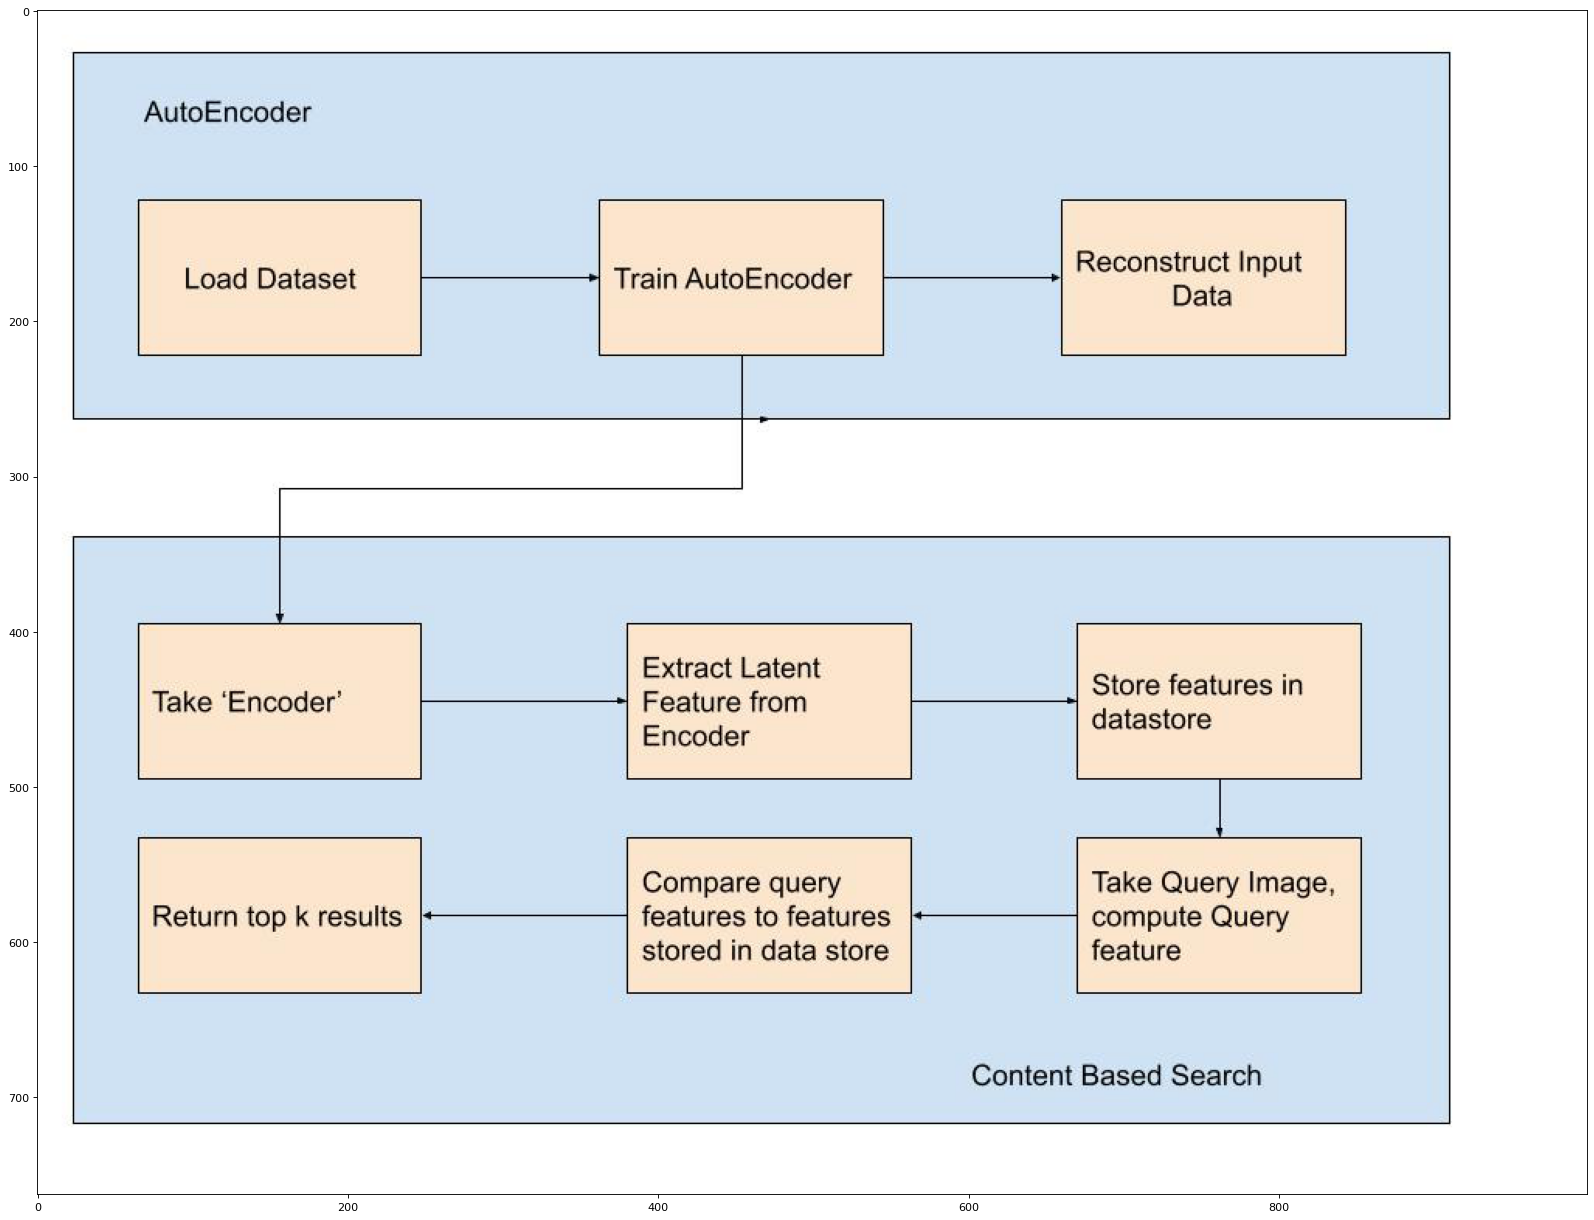

In [66]:
# Plan of action
from matplotlib.pyplot import figure

figure(figsize=(25, 20), dpi=80)
plt.imshow(plt.imread("../input/cbir-pipelin/CBIR.jpeg"), )

## 3.1 Dataset Creation and preprocessing


In [67]:
# train_df = pd.read_csv(BASE_PATH+'train.csv')
train_df.head(10)

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   
5  train_2464356923  0013e7355ffc5ff8fb1ccad3e42d92fe.jpg  bbd097a7870f4a50   
6  train_1802986387  00144a49c56599d45354a1c28104c039.jpg  f815c9bb833ab4c8   
7  train_1806152124  0014f61389cbaa687a58e38a97b6383d.jpg  eea7e1c0c04da33d   
8    train_86570404  0019a3c6755a194cb2e2c12bfc63972e.jpg  ea9af4f483249972   
9   train_831680791  001be52b2beec40ddc1d2d7fc7a68f08.jpg  e1ce953d1a70618f   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069  
5  CELANA WANITA  (BB 45-84 KG)Harem wanita (bisa...   2660605217  
6                           Jubah anak size 1-12 thn   1835033137  
7  KULOT PLISKET SALUR /CANDY PLISKET /WISH KULOT...   1565741687  
8  [LOGU] Tempelan kulkas magnet angka, tempelan ...   2359912463  
9  BIG SALE SEPATU PANTOFEL KULIT KEREN KERJA KAN...   2630990665

In [68]:
"""
Preprocess the images to feed into convolution neural network
1) Read Images
2) decode images to jpeg or proper format
3) resize or apply transformation
4) convert to tensor


"""
def preprocessImages(path,_):
    
    path = TRAIN_PATH + path
    # read the file using tf.io
    image = tf.io.read_file(path)
    # decode image to jpeg
    image = tf.image.decode_jpeg(image, channels=3)
    # resize the image
    image = tf.image.resize(image, [INP_WIDTH,INP_HEIGHT])
    # convert to tensor and normalize
    image = tf.cast(image, tf.float32)/255.0
    
    return image, image

    
    

In [69]:
# create train dataset 
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image'].values, train_df['label_group'].values))
# preprocess the train dataset to feed into deep learning model
train_dataset = train_dataset.map(preprocessImages)

## 3.2 Visualize dataset




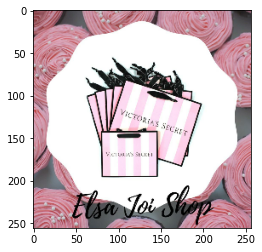

In [70]:
images = next(iter(train_dataset))
plt.imshow(images[0])

In [71]:
# convert dataset to batches
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)




## 3.3 Build Model




In [72]:
filters =[16,32,64]

def build_convolution_auto_encoder(input_size, filters=[16,32,64]):
    # create input layer
    inputs = layers.Input(shape=input_size)
    
    # iterate over filters and pass input to layers and get latern features
    for idx,_filter in enumerate(filters):
        if idx==0:
            latent_features = layers.Conv2D(filters=_filter, kernel_size=(3,3), padding='same', activation='relu')(inputs)
        else:
            latent_features = layers.Conv2D(filters=_filter, kernel_size=(3,3), padding='same', activation='relu')(latent_features)
        latent_features= layers.BatchNormalization()(latent_features)
        latent_features = layers.MaxPooling2D(pool_size=(2,2), padding="same")(latent_features)
        
    
    
    # iterate over the filters in reverse order and use transposed convolution to reconstruct the same iamge again using latent features
    
    for idx,_filter in enumerate(reversed(filters)):
        if idx==0:
            decoded_features = layers.Conv2D(filters=_filter,kernel_size=(3,3), padding="same", activation="relu")(latent_features)
        else: 
            decoded_features = layers.Conv2D(filters=_filter,kernel_size=(3,3), padding="same", activation="relu")(decoded_features)
        decoded_features = layers.UpSampling2D(size = (2, 2))(decoded_features)
        
    decoded_features = layers.Conv2D(filters = 3, kernel_size = (3, 3), padding = "same", activation = "sigmoid")(decoded_features)
    
    
    
    encoder_model  = models.Model(inputs=inputs, outputs = latent_features ) 
    
    encoder_decoder = models.Model(inputs = inputs, outputs = decoded_features)
    encoder_decoder.compile(optimizer = "Adam", loss = "binary_crossentropy")
    return encoder_decoder, encoder_model
    
    

In [73]:
tf.keras.backend.clear_session()
encoder_decoder, encoder = build_convolution_auto_encoder((256, 256, 3))
encoder_decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0   

In [74]:
IS_TRAINING = False

if IS_TRAINING:
    history = encoder_decoder.fit(
        train_dataset, epochs = 3,
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor = "train_loss", patience = 3, mode = "min"),
            tf.keras.callbacks.ModelCheckpoint(filepath = "encoder_decoder.h5", monitor = "train_loss", mode = "min", save_best_only = True, save_weights_only = True)
        ]
    )
    # Save model to disk
    encoder_decoder.save_weights('encoder_decoder.h5')
    encoder.save_weights('encoder.h5')
else:
    encoder_decoder.load_weights('../input/output-model/encoder_decoder.h5')
    encoder.load_weights('../input/output-model/encoder.h5')

## 3.4 Visualize Predictions



In [75]:
def visualize_predictions(predictions,truth, samples=5):
    # initialize our list of output images
    outputs = None
#     tf.enable_eager_execution()
    # loop over our number of output samples
    for i in range(0, samples):
        # grab the original image and reconstructed image
        true_image = (truth[i].numpy() * 255).astype("uint8")
        predicted_image = (predictions[i] * 255).astype("uint8")

        # stack the original and reconstructed image side-by-side
        output = np.hstack([true_image, predicted_image])

        # if the outputs array is empty, initialize it as the current
        # side-by-side image display
        if outputs is None:
            outputs = output

        # otherwise, vertically stack the outputs
        else:
            outputs = np.vstack([outputs, output])

    # return the output images
#     plt.imshow(outputs)
    return outputs

In [76]:
# create samples and prepare to array

random_sample = []
predictions_sample = []
for idx, batch in enumerate(train_dataset):
    # Extract first 5 sample from 1st batch
    random_sample=list(batch[0][:5,:])
    # get prediction for first 5 sample from 1st batch
    predictions_sample = list(encoder_decoder.predict(batch[0][:5,:]))
    break


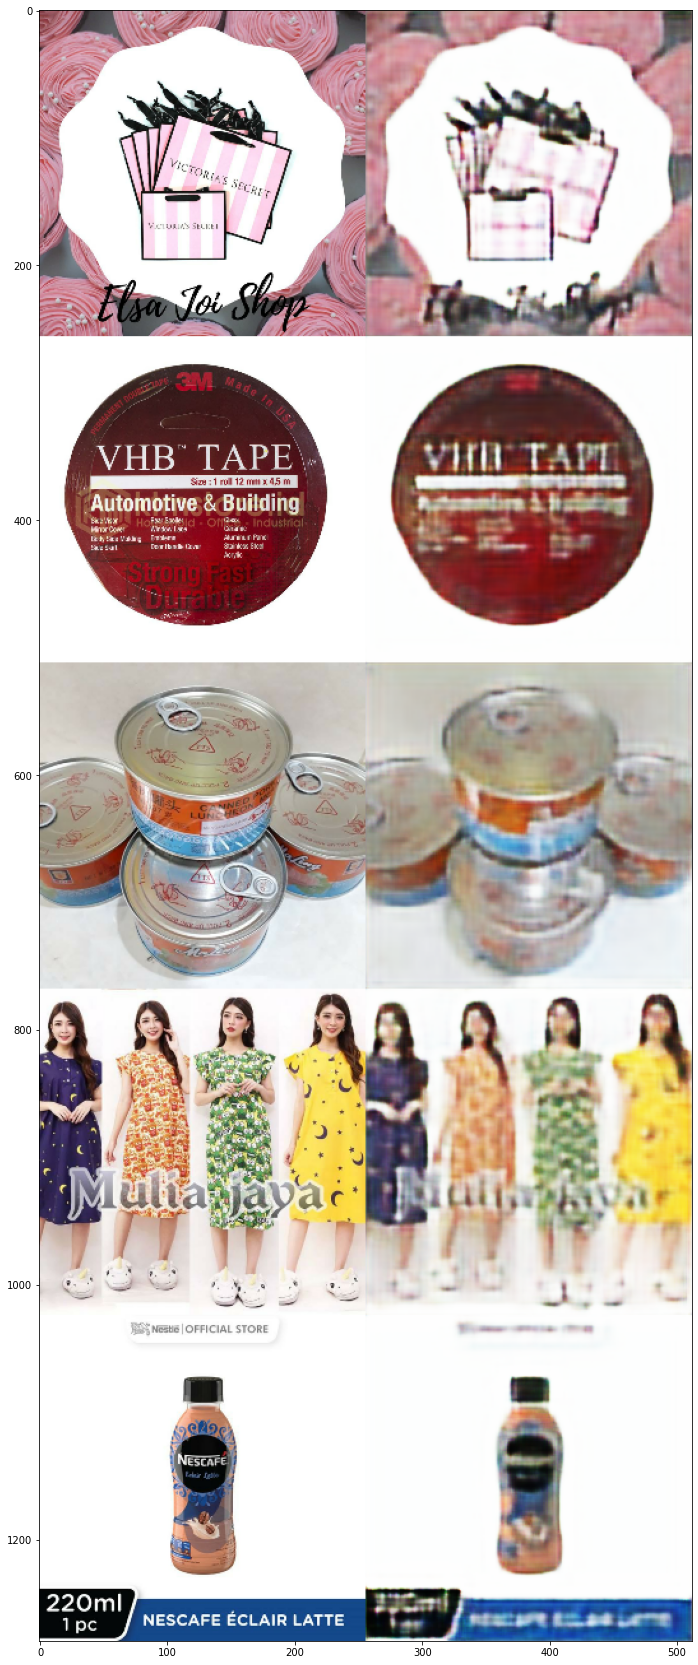

In [77]:

vis = visualize_predictions(predictions_sample, random_sample)
# write image to output
cv2.imwrite('viz.jpeg', vis)
plt.figure(figsize=(15, 30))
plt.imshow(vis)

## 3.5  Observation

In a single epoch of training, we are able to reconstruct the image which looks like a original image, generated images are blury, possible reason could be MSE loss and architectural design and training issue.


# 4 Load Models and create indexing




In [78]:
tf.keras.backend.clear_session()
encoder_decoder, encoder = build_convolution_auto_encoder((256, 256, 3))
encoder_decoder.load_weights('../input/output-model/encoder_decoder.h5')
encoder.load_weights('../input/output-model/encoder.h5')

In [79]:
def preprocessImages(path,index):
    
    path = TRAIN_PATH + path
    # read the file using tf.io
    image = tf.io.read_file(path)
    # decode image to jpeg
    image = tf.image.decode_jpeg(image, channels=3)
    # resize the image
    image = tf.image.resize(image, [INP_WIDTH,INP_HEIGHT])
    # convert to tensor and normalize
    image = tf.cast(image, tf.float32)/255.0
    
    return image, index
# create train dataset 
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image'].values, train_df.index.values))
# preprocess the train dataset to feed into deep learning model
train_dataset = train_dataset.map(preprocessImages)
    
    

In [80]:
train_dataset_sample = train_df.sample(n = 1000,random_state=10)
indexes=train_dataset_sample.index
train_dataset_sample = tf.data.Dataset.from_tensor_slices((train_dataset_sample['image'].values, train_dataset_sample.index.values))
train_dataset_sample = train_dataset_sample.map(preprocessImages)


In [81]:
# make predictions over train_dataset
from tqdm import tqdm
test_encoded = []

for image in tqdm(train_dataset_sample.batch(64)):
    batch_size = image[0].shape[0]
    encoded = encoder.predict(image[0])
    test_encoded.append(encoded.reshape(batch_size, -1))
    
test_encoded = np.concatenate(test_encoded, axis = 0)
    


100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


In [82]:
data_dict = {"indexes": indexes, "features": test_encoded}

# write the data dictionary to disk
print("[INFO] saving index...")
f = open('indexing1.pickle', "wb")
f.write(pickle.dumps(data_dict))
f.close()

[INFO] saving index...


In [83]:
def euclidean(a, b):
    return np.linalg.norm(a - b)

# 5 Visualize top similar product

In [84]:
def search_similar_images(queryFeatures, index, maxResults=5):
    results=[]
    
    # loop over our index
    for i in range(0, len(index["features"])):
        # compute the  distance euclidean between our query features
        # and the features for the current image in our index, then
        dist = euclidean(queryFeatures, index["features"][i])
        results.append((dist, index['indexes'][i]))

    # sort the results and grab the top ones
    results = sorted(results)[:maxResults]

    # return the list of results
    return results

In [85]:
# searchSimialar image
index = pickle.loads(open('../input/indexingfile/indexing.pickle', "rb").read())


    


In [86]:
train_indexes = index['indexes']
train_Features = index['features']

indexes_Features=dict()
for k,v in  zip(train_indexes,train_Features):
    indexes_Features[k]=v

In [87]:

# read the file using tf.io
qimage = tf.io.read_file('../input/shopee-product-matching/train_images/0000a68812bc7e98c42888dfb1c07da0.jpg')
# decode image to jpeg
qimage = tf.image.decode_jpeg(qimage, channels=3)
# resize the image
qimage = tf.image.resize(qimage, [INP_WIDTH,INP_HEIGHT])
# convert to tensor and normalize
qimage = tf.cast(qimage, tf.float32)/255.0

In [88]:
qimage =tf.expand_dims(qimage, 0)
qimage = encoder.predict(qimage)
feature_query = qimage.reshape(1, -1)
feature_query.shape

(1, 65536)

In [89]:
def search_similar_images(queryFeatures, index, maxResults=5):
    results=[]
    
    # loop over our index
    for i in range(0, len(index["features"])):
        # compute the  distance euclidean between our query features
        # and the features for the current image in our index, then
        dist = euclidean(queryFeatures, index["features"][i])
        if index['indexes'][i] == 13168:
            print(dist)
        results.append((dist, index['indexes'][i]))

    # sort the results and grab the top ones
    results = sorted(results)[:maxResults]

    # return the list of results
    return results

In [90]:
results = search_similar_images(feature_query,index)

440.81897


In [91]:
results
# ../input/shopee-product-matching/train_images/0000a68812bc7e98c42888dfb1c07da0.jpg
res_index= [0]
res_index.extend([i[1] for i in results])
distance_matrix=[(0,0)]
distance_matrix.extend(results)
print(res_index)

[0, 29316, 19243, 12681, 20791, 14733]


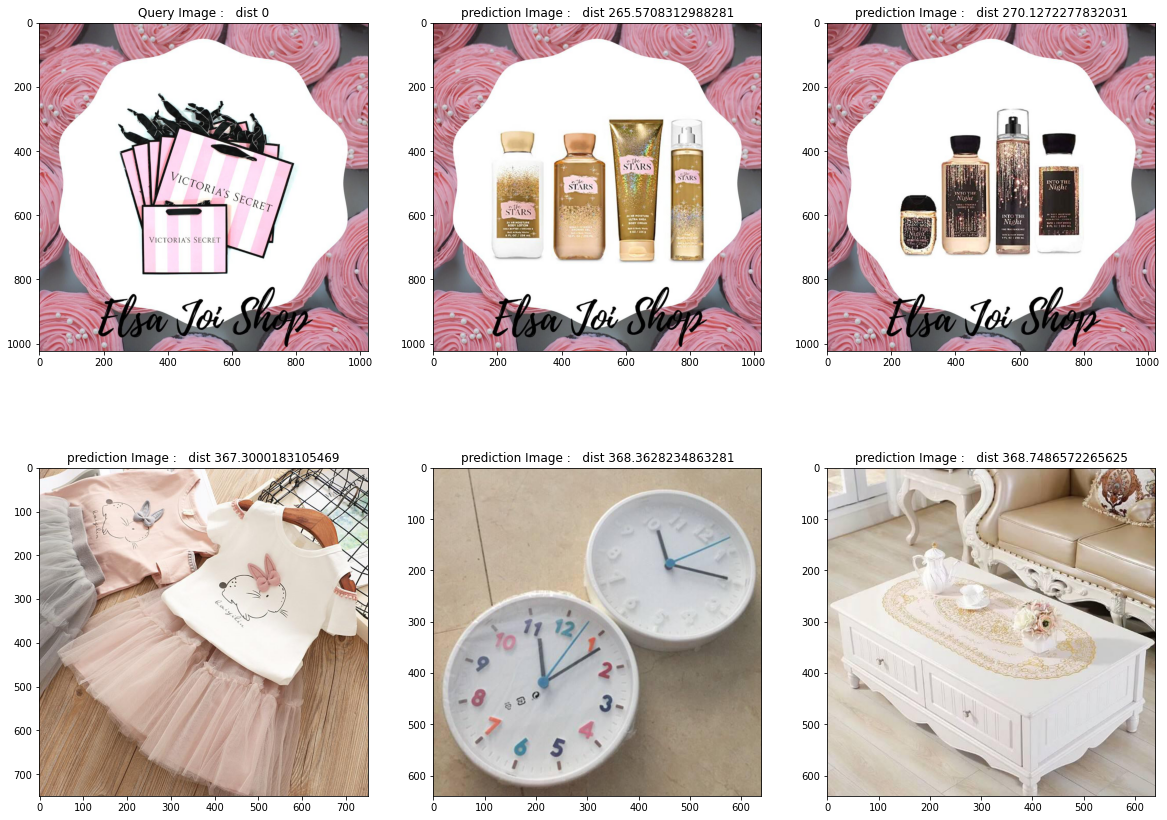

In [92]:
# take indexes
sample_indexes = res_index
# set seed 
np.random.seed(100)

# create subplot 4 rows 3 columns
figure, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,15))
ax = ax.flatten()

for idx,data in enumerate(distance_matrix):
    img_id = train_df.loc[data[1]]["image"]
    ax[idx].imshow(im.imread("../input/shopee-product-matching/train_images/{}".format(img_id)).squeeze())
    
    if idx == 0:
        ax[idx].title.set_text("Query Image :   dist {}".format( data[0]))
    else:
        ax[idx].title.set_text("prediction Image :   dist {}".format( data[0]) )                      
        